In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
def f(x):
  return 2*x**2 - 3*x + 4

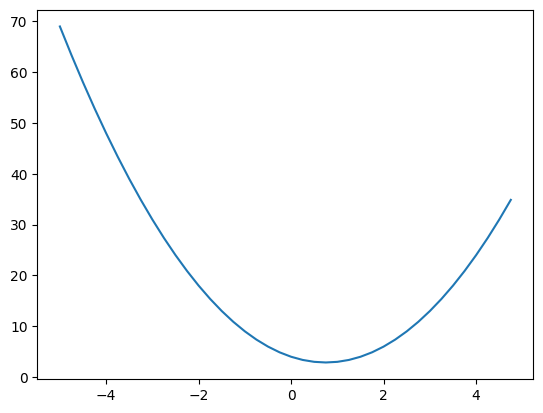

In [ ]:
arr=np.arange(-5,5,.25)
y_arr=f(arr)
y_arr
plt.plot(arr,y_arr)

In [ ]:
x = 6
h = 0.001
(f(x+h)-f(x))/h

21.002000000009957

In [258]:
import math
class value:
  def __init__(self, data, _children = (), op = ""):
    self.data = data
    self._prev = set(_children)
    self._op = op
    self.grad = 0.0
    self._backward = lambda : None

  def __repr__(self):
    return f"value(data={self.data};_prev={self._prev},_op={self._op})"


  def __add__(self,other):
    other = other if isinstance(other,value) else value(other)
    out = value(self.data + other.data , (self , other) , '+')

    def _backward():
      self.grad +=  out.grad     # each variable might contribute to different nueron , which will lead gradient from differet out
      other.grad += out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self.__add__(other)


  def __mul__(self,other):
    other = other if isinstance(other,value) else value(other)
    out = value(self.data * other.data , (self , other) , '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self,other):
    return self.__mul__(other)


  def __sub__(self, other):
      return self + (-other)


  def __rsub__(self,other):
    return self.__sub__(other)

  def __truediv__(self, other):
    return self * other**-1


  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only supporting int/float power"
    out = value(self.data ** other,(self,),"**")

    def _backward():
      self.grad += (other * ( self.data ** (other -1)) * out.grad)

    out._backward = _backward

    return out


  def tanh(self):
    x = self.data
    t = (math.exp( 2 * x) -1 ) / (math.exp(2 * x) +1)
    out = value(t , (self, ) , 'tahn')

    def _backward():
      self.grad += ( 1 - t ** 2 ) * out.grad
    out._backward = _backward

    return out

  def __neg__(self):
      return self * -1

  def __radd__(self, other): # other + self
        return self + other

  def __rsub__(self, other): # other - self
      return other + (-self)

  def relu(self):
    out = value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
        self.grad += (out.data > 0) * out.grad
    out._backward = _backward

    return out

  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)


    self.grad = 1
    for v in reversed(topo):
        v._backward()



In [212]:
w1, w2, w3, w4 , b = value(.4) , value(.2) , value(.7) , value(.5) , value(.3)
x1, x2 = value(7) , value(6)




w1x1 = w1 * x1
w2x2 = w2 * x2

w3w1x1 = w3 * w1x1

w4w2x2 = w4 * w2x2





Last_w1, Last_w2 = value(0.23) ,value(0.68)

X1 = Last_w1 * w3w1x1
X2 = Last_w2 * w4w2x2

y = X1 + X2

y = y - b

res = y.tanh()
k = res ** 3
k.grad = 1


In [172]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout


# Function to create a graph from a value object
def create_graph(root, graph=None):
    if graph is None:
        graph = nx.DiGraph()

    if root._op:
        label = f"{root._op}"
        if root._op in ['+', '*','-']:
            temp = list(root._prev)
            label = f"{str(temp[0].data)[:3]} {root._op} {str(temp[1].data)[:3]}"
        else:
          label = f"{root._op}::{str(root.data)[:4]}"

    else:
        label = f"{root.data:2f}"

    graph.add_node(root, label=label ,grad = root.grad)

    for child in root._prev:
        graph.add_edge(child, root)
        create_graph(child, graph)

    return graph

def add_grad_text(graph, pos):
    for node, (x, y) in pos.items():
        grad_label = str(graph.nodes[node]['grad'])[:6]
        plt.annotate(f'Grad: {grad_label}', xy=(x, y), xytext=(-28, 22), textcoords='offset points', fontsize=8, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7))



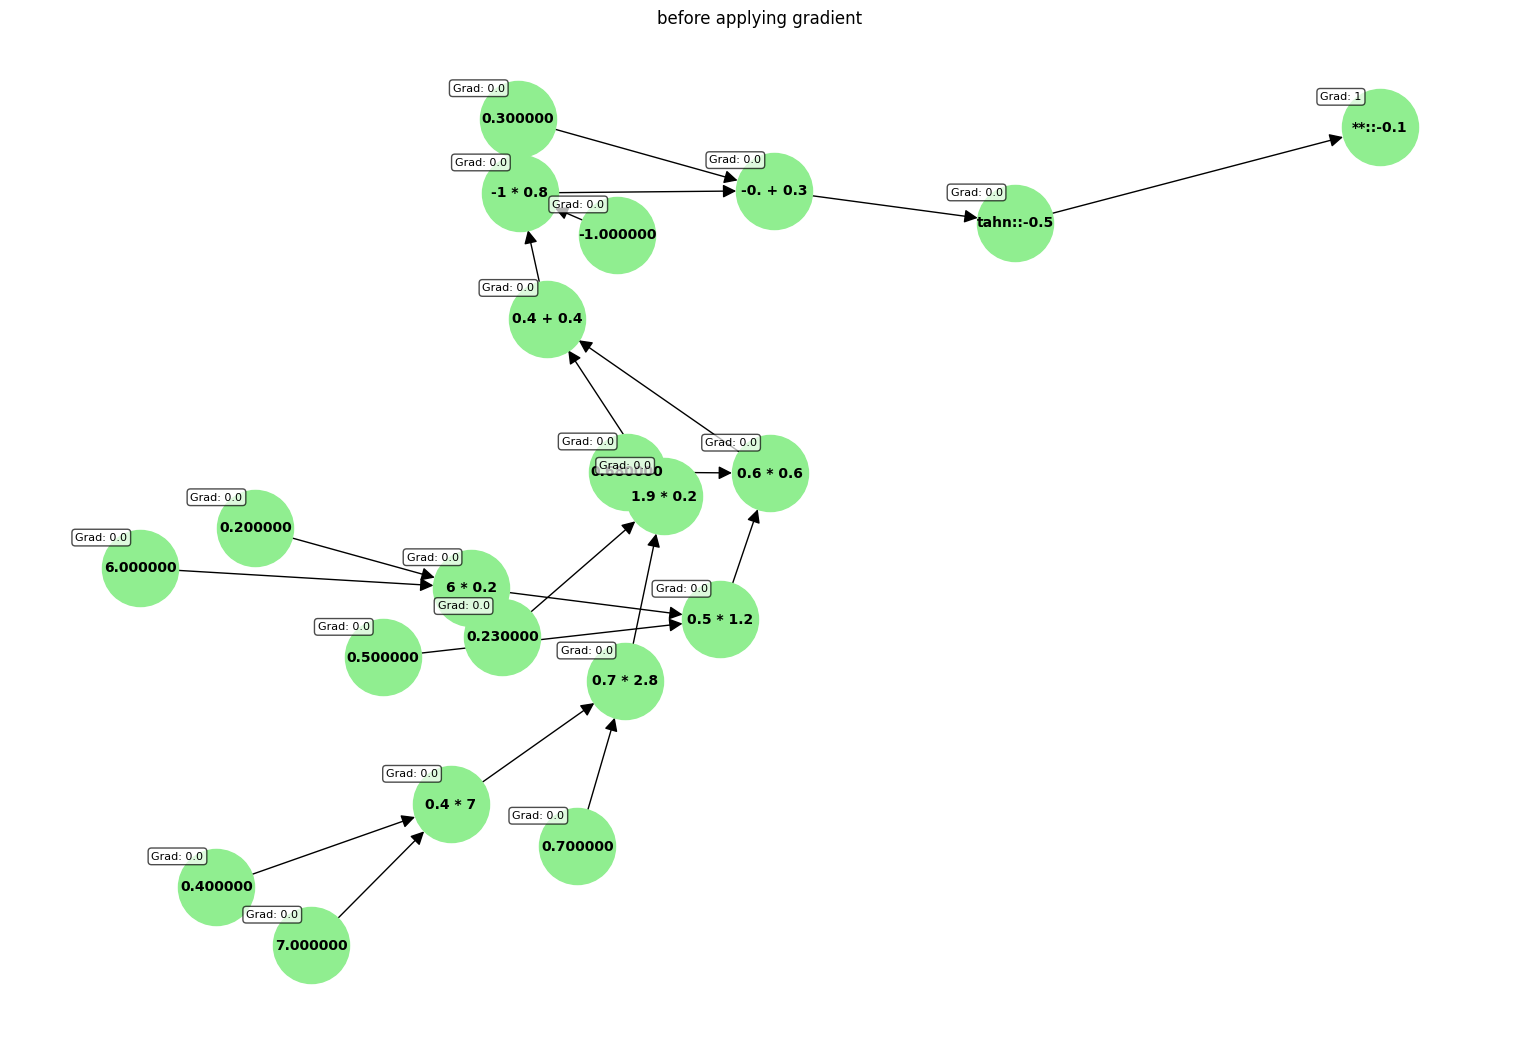

In [213]:
graph = create_graph(k)

plt.figure(figsize=(15, 10))  # Adjust figure size
pos = nx.spring_layout(graph)
labelsN = nx.get_node_attributes(graph, 'label')
nx.draw(graph, pos, with_labels=True, labels=labelsN, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', arrowsize=20)
add_grad_text(graph, pos)
plt.title('before applying gradient')
plt.show()

In [5]:
res.backward()

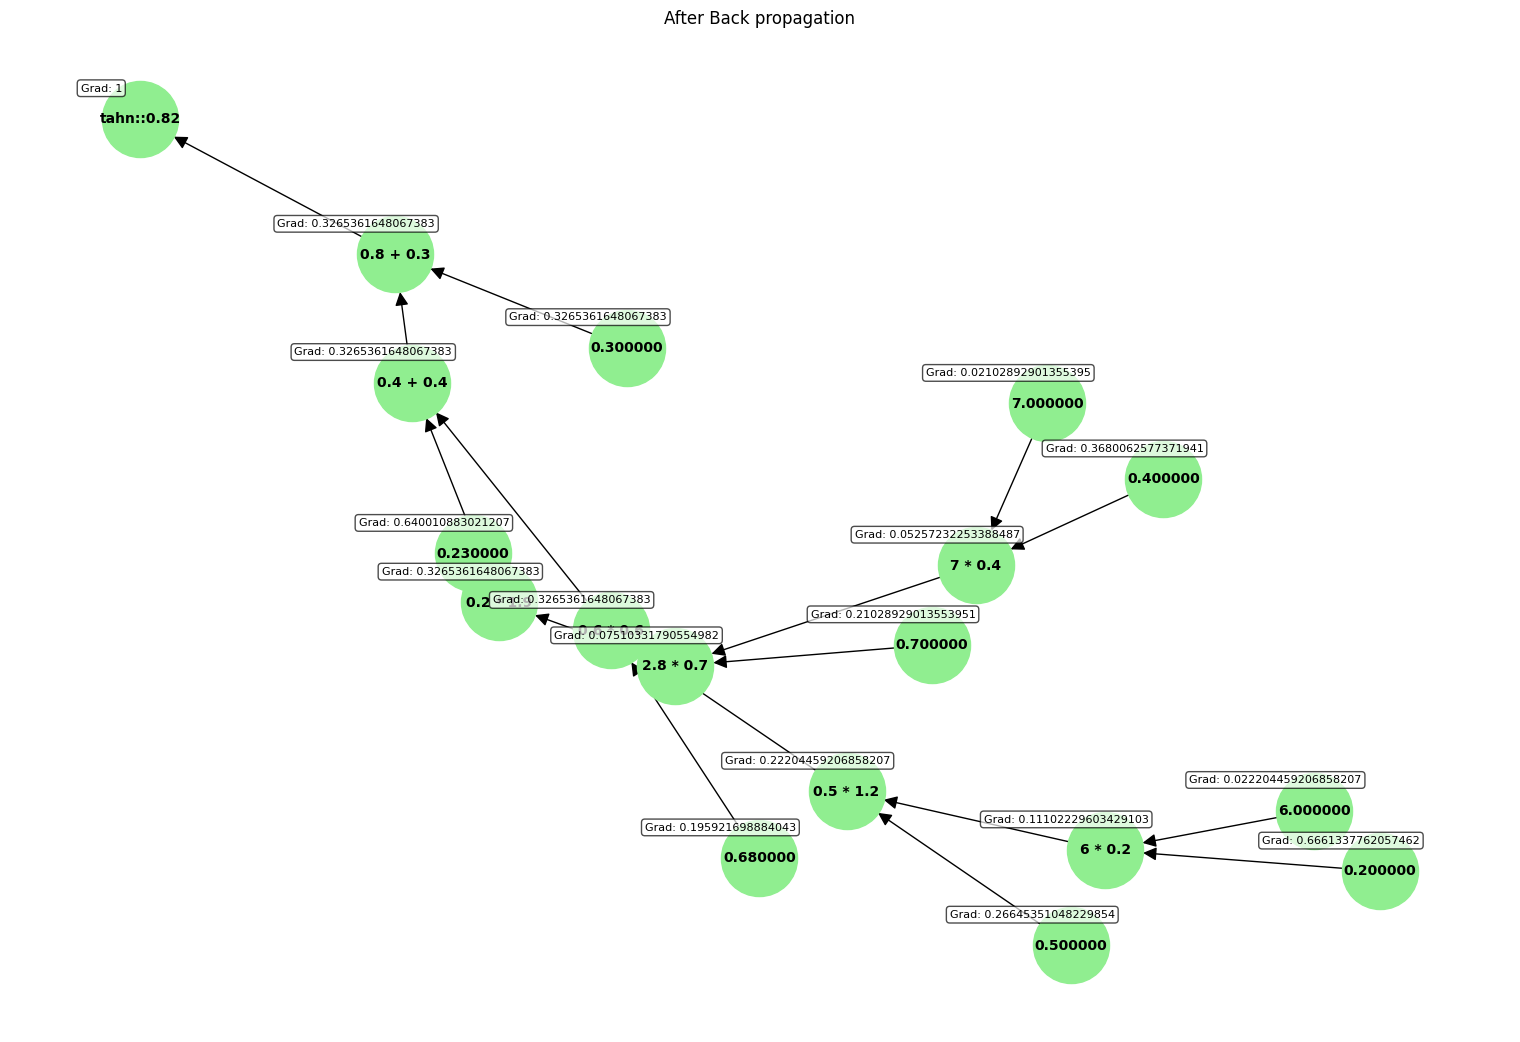

In [7]:
graph = create_graph(res)

plt.figure(figsize=(15, 10))  # Adjust figure size
pos = nx.spring_layout(graph)
labelsN = nx.get_node_attributes(graph, 'label')
nx.draw(graph, pos, with_labels=True, labels=labelsN, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', arrowsize=20)
add_grad_text(graph, pos)
plt.title('After Back propagation')
plt.show()

# SAME THING USING **PYTORCH**

In [69]:
import torch

w1, w2, w3, w4 , b = torch.Tensor([.4]).double() , torch.Tensor([.2]).double() , torch.Tensor([.7]).double() , torch.Tensor([.5]).double() , torch.Tensor([.3]).double()
x1, x2 = torch.Tensor([7]) , torch.Tensor([6])

w1.requires_grad = True
w2.requires_grad = True
w3.requires_grad = True
w4.requires_grad = True
b.requires_grad = True

x1.requires_grad = True
x2.requires_grad = True



w1x1 = w1 * x1
w2x2 = w2 * x2


w3w1x1 = w3 * w1x1

w4w2x2 = w4 * w2x2





Last_w1, Last_w2 = torch.tensor([0.23]) ,torch.tensor([0.68])

X1 = Last_w1 * w3w1x1
X2 = Last_w2 * w4w2x2

y = X1 + X2

y = y + b

res = y.tanh()



In [70]:
res.backward()

In [69]:
print(f"w1 :: {w1.grad.item()}")
print(f"w2 :: {w2.grad.item()}")
print(f"w3 :: {w3.grad.item()}")
print(f"w4 :: {w4.grad.item()}")
print(f"b :: {b.grad.item()}")
print(f"x1 :: {x1.grad.item()}")
print(f"x2 :: {x2.grad.item()}")


w1 :: 0.3680062403215004
w2 :: 0.666133750948199
w3 :: 0.2102892868984742
w4 :: 0.2664535043497462
b :: 0.32653614899092814
x1 :: 0.021028928458690643
x2 :: 0.022204458713531494


# Creating a **Neural Network** :  using **value** class

In [174]:
import random
import numpy as np
class Neuron:
  def __init__(self,N_in):
    self.w = [value(random.uniform(-1, 1)) for _ in range(N_in)]
    self.b = value(random.uniform(-1, 1))

  def __call__(self,x):
    acti = sum((wi * xi for wi,xi in zip(self.w, x)),self.b)
    out = acti.tanh()
    return out

In [175]:
n = Neuron(3)
x = [2,.3,-2]
n(x).data

-0.9909054128211948

In [176]:
class Layer:
  def __init__(self, N_in, N_out):
    self.neurons = [Neuron(N_in) for _ in range(N_out)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs


In [177]:
l = Layer(3,4)
outs = l(x)
print('[',end=' ')
for out in outs:
  print(out.data,end=' ')
print(']')

[ 0.990152553153292 -0.42902522649571717 0.8847234289787584 -0.9550776412160659 ]


In [178]:
class MLP: # Multi Layer Perceptron
  def __init__(self, N_in , Net_size_arr):
    whole_netword = [N_in] + Net_size_arr
    self.layers = [Layer(whole_netword[i],whole_netword[i+1]) for i in range(len(Net_size_arr))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

In [179]:
M = MLP(3,[4,2,1])
out = M(x)


In [180]:
out.data

-0.2370721056371993

In [ ]:
out.grad = 1
out.backward()
graph = create_graph(out)

plt.figure(figsize=(25, 10))  # Adjust figure size
pos = nx.spring_layout(graph)
labelsN = nx.get_node_attributes(graph, 'label')
nx.draw(graph, pos, with_labels=True, labels=labelsN, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', arrowsize=20)
add_grad_text(graph, pos)
plt.title('After Back propagation')
plt.show()

# **Merged code**

In [259]:
import random

class Neuron:
  def __init__(self,N_in):
    self.w = [value(random.uniform(-1, 1)) for _ in range(N_in)]
    self.b = value(random.uniform(-1, 1))

  def __call__(self,x):
    acti = sum((wi * xi for wi,xi in zip(self.w, x)),self.b)
    out = acti.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, N_in, N_out):
    self.neurons = [Neuron(N_in) for _ in range(N_out)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, N_in , N_out):
    net = [N_in] + N_out
    self.layers = [Layer(net[i],net[i+1]) for i in range(len(N_out))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [272]:
n = MLP(3,[4,3,1])
X = [
    [2.0 , 3.0 , -1.0],
    [3.0 , -1.0 , 0.5],
    [0.5 , 1.0 , 1.0],
    [1.0 , 1.0 , -1.0]
]

ys = [1.0 ,-1.0 , -1.0, 1.0]


(0.07524324431477629, 0.8469812981102212)

# Following is the loop for Optimiztion

In [342]:
ypred = [n(x) for x in X]

loss = sum([(yi - yz)**2 for yi,yz in zip(ys,ypred)])

loss.backward()
n.layers[0].neurons[0].w[0].grad , n.layers[0].neurons[0].w[0].data

(0.6564557448808667, 0.08081442067866901)

In [343]:
for p in n.parameters():
  p.data+= -0.1 * p.grad

In [344]:
n.layers[0].neurons[0].w[0].data

0.015168846190582341

In [346]:
n([2.0 , 3.0 , -1.0]).data

0.9999999999937584

In [347]:
n([3.0 , -1.0 , 0.5]).data

-0.9999999999487216

# Wrapping things together

In [348]:
n = MLP(3,[4,3,1])
X = [
    [2.0 , 3.0 , -1.0],
    [3.0 , -1.0 , 0.5],
    [0.5 , 1.0 , 1.0],
    [1.0 , 1.0 , -1.0]
]

ys = [1.0 ,-1.0 , -1.0, 1.0]

first_pred = [n(x) for x in X]


epoch = 20
lr = 1e-2

for i in range(epoch):

  ypred = [n(x) for x in X]

  #loss
  loss = sum([(yi - yz)**2 for yi,yz in zip(ys,ypred)])

  # flush previous grad
  for p in n.parameters():
    p.grad = 0.0

  # back_propagation
  loss.backward()

  print(f'k:: {i} loss :: {loss.data}')
  for p in n.parameters():
    p.data+= -lr * p.grad

k:: 0 loss :: 5.584205131453073
k:: 1 loss :: 5.200294827136621
k:: 2 loss :: 4.428783985538844
k:: 3 loss :: 3.6241549266923516
k:: 4 loss :: 3.5955478708760027
k:: 5 loss :: 4.242359844746163
k:: 6 loss :: 4.8408892494123865
k:: 7 loss :: 5.132395608258534
k:: 8 loss :: 5.105943492093207
k:: 9 loss :: 4.753669690412942
k:: 10 loss :: 4.050348260658758
k:: 11 loss :: 3.1113993855527946
k:: 12 loss :: 2.3974731210977636
k:: 13 loss :: 2.1241552916280844
k:: 14 loss :: 1.7495181954591117
k:: 15 loss :: 1.2219223737648777
k:: 16 loss :: 0.71670921350515
k:: 17 loss :: 0.33324876691102945
k:: 18 loss :: 0.12982214280903256
k:: 19 loss :: 0.04710251756641591


In [349]:
new_pred = [n(x) for x in X]

In [372]:
print('FIRST PRED                     NEW PRED                    Target')
for i in zip(first_pred,new_pred,ys):
  print(f'{str(i[0].data)[:10]}                    {str(i[1].data)[:10]}                     {i[2]}')

FIRST PRED                     NEW PRED                    Target
-0.7298430                    0.91769496                     1.0
-0.7113106                    -0.9428494                     -1.0
-0.7226423                    -0.9768904                     -1.0
-0.5593522                    0.91573148                     1.0
